In [1]:
import os
import sys
import warnings

from glob import glob
import random
import datetime
import re
from tqdm import tqdm

import pandas as pd
import numpy as np

from google.cloud import bigquery

import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

import gspread
from oauth2client.service_account import ServiceAccountCredentials

from plotnine import *

warnings.filterwarnings('ignore')

In [2]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
font = fm.FontProperties(fname=path, size=9)

NanumGothic


In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)
pd.options.display.float_format = '{:.2f}'.format

In [4]:
def read_bql(file_name) :
    with open(file_name, "r") as f :
        bql = f.read()
    return bql


def bigquery_to_pandas(query_string) :

    credential_path = '../99_credential/lawtalk-bigquery-2bfd97cf0729.json'
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = credential_path
    bqclient = bigquery.Client()
    
    b = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(
            # Optionally, explicitly request to use the BigQuery Storage API. As of
            # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
            # API is used by default.
            create_bqstorage_client=True,
        )
    )
    
    return b

In [8]:
def get_gini(df, val_col, group_key = None, color = "red", plot_tf = True) :
    '''
    gini 계수 및 그래프(로렌츠커브)를 그려주는 함수
    df : 지니 계수를 뽑을 데이터프레임 -- pd.DataFrame
    val_col : 지니 계수 대상 컬럼명 -- str
    group_key : 로렌츠커브 그룹화할(컬러를 다르게 지정할) 컬럼명 -- str, default = None
    color  : 로렌츠커브를 나타낼 막대의 색깔 -- str, default = "red"
    plot_tf : 로렌츠커브 프린트에 대한 boolean -- boolean, default = True
    '''
    tmp = df.copy()
    tmp["ratio"] = tmp[val_col] / tmp[val_col].max()
    tmp["rnk"] = tmp.ratio.rank(method = "first")  / tmp.shape[0]
    tmp = tmp.sort_values("rnk")
    tmp["eq_line"] = [i / tmp.shape[0] for i in range(tmp.shape[0])]
    
    lorenz = (tmp.rnk * tmp.shape[0] * (tmp.ratio / tmp.shape[0])).sum()
    tri = ((tmp.rnk * tmp.shape[0]).max() * tmp.rnk.max()) / 2
    if group_key == None :
        col_plot = geom_col(mapping = aes(x = "rnk", y = "ratio"), fill = color, alpha = 0.6)
    else :
        col_plot = geom_col(mapping = aes(x = "rnk", y = "ratio", fill = group_key), alpha = 0.6)

    if plot_tf == True :

        print((
            ggplot(data = tmp) +
            col_plot +
            geom_line(mapping = aes(x = "rnk", y = "eq_line"), group = 1) +
            theme_bw() +
            theme(figure_size = (10, 7), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank())
        ))

        
    
    return (tri - lorenz) / tri

def ad_active(df, d) :
    return (df.adorders_start_date <= d) & (df.adorders_end_date >= d) & ~((df.pauseHistory_startAt_date <= d) & (df.pauseHistory_endAt_date >= d)) & (df.adorders_status == 'apply') & (df.adpayments_status == 'paid')

def ad_active_dates(df, date_list) :
    return pd.concat([df[ad_active(df, d)] for d in date_list]).drop_duplicates()

def prefix_rnk(df, str_cols, y_cols, zfill_ns = 2) :
    return df[y_cols].rank(ascending = False).astype(int).astype(str).str.zfill(zfill_ns) + "_" + df[str_cols]

In [9]:
adorder_with_tag = bigquery_to_pandas(read_bql("../bql/adorder_with_tag.bql"))

In [10]:
adorder_with_tag = adorder_with_tag.sort_values(["slug", "tag_createdAt"]).drop_duplicates(subset = ["adCategory_name", "slug"], keep = "last")

강조 태그를 사용하는 총 변호사 비율

In [98]:
adorder_with_tag[adorder_with_tag.tags.notna()].lawyer.nunique() / adorder_with_tag.lawyer.nunique()

0.44819819819819817

In [12]:
advice = bigquery_to_pandas(read_bql("../bql/advice_query.bql"))
# adorders = bigquery_to_pandas(read_bql("../bql/adorders_query.bql"))

In [31]:
bdate_range = pd.date_range(datetime.date(2022, 8, 8), datetime.date(2022, 8, 22))
adate_range = pd.date_range(datetime.date(2022, 8, 23), datetime.date(2022, 9, 7))

In [32]:
# extract_adorders = ad_active_dates(adorders, date_range)
bextract_advice = advice[(advice.createdAt.dt.date.isin(bdate_range.date))]
aextract_advice = advice[(advice.createdAt.dt.date.isin(adate_range.date))]

In [33]:
bextract_advice = pd.merge(bextract_advice, adorder_with_tag[["lawyer", "slug"]], left_on = "lawyer_id", right_on = "lawyer", how = "left")
aextract_advice = pd.merge(aextract_advice, adorder_with_tag[["lawyer", "slug", "tags"]], left_on = "lawyer_id", right_on = "lawyer", how = "left")

In [34]:
extract_advice = pd.concat([bextract_advice.assign(tp = "b"), aextract_advice.assign(tp = "a")])

In [100]:
extract_advice = extract_advice.assign(tags_exist = lambda x : np.where(x.tags.notna(), "t", "f"))

In [101]:
extract_advice = extract_advice.sort_values(["_id", ]).drop_duplicates(subset = ["_id", "slug", "tp"])

강조태그 전 상담 변호사수 : 290
강조태그 전 상담 수 : 3988
       slug tags_exist  _id
0  9054-박성현  f          101
1  2359-이재희  f          91 
2  5018-김수한  f          80 
3  8801-하나   f          68 
4  5327-전선재  f          68 


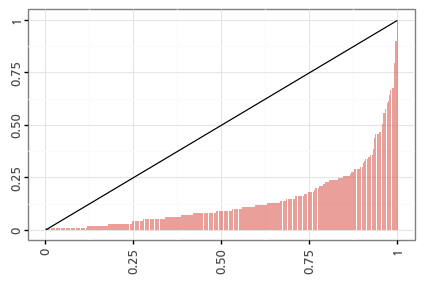


강조 태그 전 분야 불평등도 = 0.7860871534399548


In [102]:
print("강조태그 전 상담 변호사수 : {}".format(extract_advice[extract_advice.tp == "b"].lawyer_id.nunique()))
print("강조태그 전 상담 수 : {}".format(extract_advice[extract_advice.tp == "b"]._id.nunique()))

print(extract_advice[extract_advice.tp == "b"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index().head())
print("강조 태그 전 분야 불평등도 = {}".format(get_gini(extract_advice[extract_advice.tp == "b"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index(), "_id", group_key = "tags_exist")))

In [103]:
tmp = extract_advice[extract_advice.tp == "a"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index()

강조태그 전 상담 변호사수 : 297
강조태그 전 상담 수 : 4039
       slug tags_exist  _id
0  2359-이재희  t          103
1  9054-박성현  t          89 
2  5447-서아람  t          74 
3  9403-김현중  t          64 
4  2581-오현석  f          59 


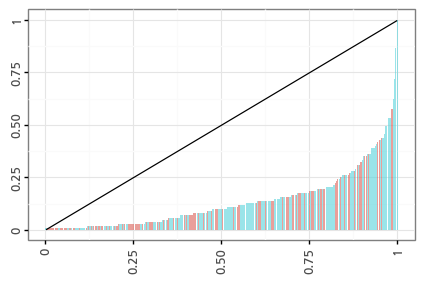


강조 태그 전 분야 불평등도 = 0.7906865471145851


In [104]:
print("강조태그 전 상담 변호사수 : {}".format(extract_advice[extract_advice.tp == "a"].lawyer_id.nunique()))
print("강조태그 전 상담 수 : {}".format(extract_advice[extract_advice.tp == "a"]._id.nunique()))

print(extract_advice[extract_advice.tp == "a"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index().head())
print("강조 태그 전 분야 불평등도 = {}".format(get_gini(extract_advice[extract_advice.tp == "a"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index(), "_id", group_key = "tags_exist")))

In [105]:
# extract_adorders = ad_active_dates(adorders, date_range)
bextract_advice = advice[(advice.adCategory_name != '기타') & (advice.createdAt.dt.date.isin(bdate_range.date))]
aextract_advice = advice[(advice.adCategory_name != '기타') & (advice.createdAt.dt.date.isin(adate_range.date))]

In [106]:
bextract_advice = pd.merge(bextract_advice, adorder_with_tag[["lawyer", "slug"]], left_on = "lawyer_id", right_on = "lawyer", how = "left")
aextract_advice = pd.merge(aextract_advice, adorder_with_tag[["lawyer", "slug", "tags"]], left_on = "lawyer_id", right_on = "lawyer", how = "left")

In [107]:
extract_advice = pd.concat([bextract_advice.assign(tp = "b"), aextract_advice.assign(tp = "a")])

In [108]:
extract_advice = extract_advice.assign(tags_exist = lambda x : np.where(x.tags.notna(), "t", "f"))

In [109]:
extract_advice = extract_advice.sort_values(["_id", ]).drop_duplicates(subset = ["_id", "slug", "tp"])

In [110]:
def get_gini(df, val_col, group_key = None, color = "red", plot_tf = True) :
    '''
    gini 계수 및 그래프(로렌츠커브)를 그려주는 함수
    df : 지니 계수를 뽑을 데이터프레임 -- pd.DataFrame
    val_col : 지니 계수 대상 컬럼명 -- str
    group_key : 로렌츠커브 그룹화할(컬러를 다르게 지정할) 컬럼명 -- str, default = None
    color  : 로렌츠커브를 나타낼 막대의 색깔 -- str, default = "red"
    plot_tf : 로렌츠커브 프린트에 대한 boolean -- boolean, default = True
    '''
    tmp = df.copy()
    tmp["ratio"] = tmp[val_col] / tmp[val_col].max()
    tmp["rnk"] = tmp.ratio.rank(method = "first")  / tmp.shape[0]
    tmp = tmp.sort_values("rnk")
    tmp["eq_line"] = [i / tmp.shape[0] for i in range(tmp.shape[0])]
    
    lorenz = (tmp.rnk * tmp.shape[0] * (tmp.ratio / tmp.shape[0])).sum()
    tri = ((tmp.rnk * tmp.shape[0]).max() * tmp.rnk.max()) / 2
    if group_key == None :
        col_plot = geom_col(mapping = aes(x = "rnk", y = "ratio"), fill = color, alpha = 0.6)
    else :
        col_plot = geom_col(mapping = aes(x = "rnk", y = "ratio", fill = group_key), alpha = 0.6)

    if plot_tf == True :

        print((
            ggplot(data = tmp) +
            col_plot +
            geom_line(mapping = aes(x = "rnk", y = "eq_line"), group = 1) +
            theme_bw() +
            theme(figure_size = (5, 3), text = element_text(angle = 90, fontproperties = font), axis_title=element_blank(), legend_position = "none")
        ))

        
    
    return (tri - lorenz) / tri

임대차 분야
강조태그 전 상담 변호사수 : 61
강조태그 후 상담 변호사수 : 72
강조태그 전 상담 수 : 369
강조태그 후 상담 수 : 352

상담 변호사의 강조태그 여부
tags_exist
f    27
t    45
Name: lawyer_id, dtype: int64


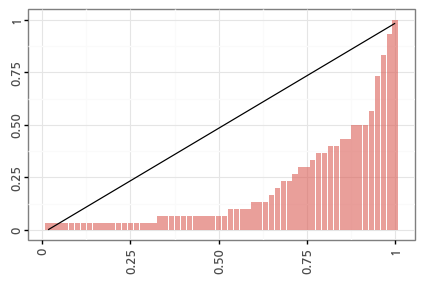


임대차 강조 태그 전 분야 불평등도 = 0.6781666666666666


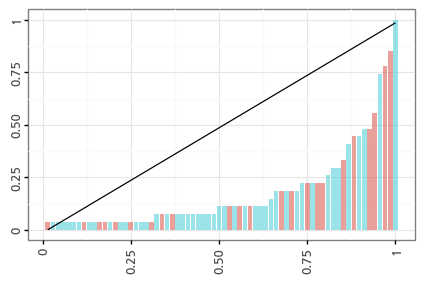


임대차 강조 태그 후 분야 불평등도 = 0.7193867743175701






--------------------------------------------------
디지털 성범죄 분야
강조태그 전 상담 변호사수 : 63
강조태그 후 상담 변호사수 : 72
강조태그 전 상담 수 : 302
강조태그 후 상담 수 : 291

상담 변호사의 강조태그 여부
tags_exist
f    27
t    45
Name: lawyer_id, dtype: int64


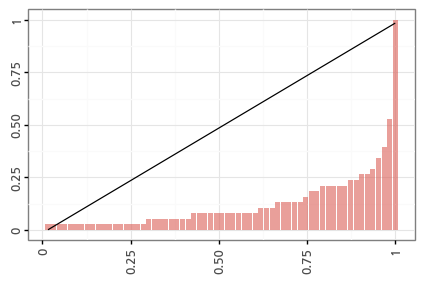


디지털 성범죄 강조 태그 전 분야 불평등도 = 0.8083966530081819


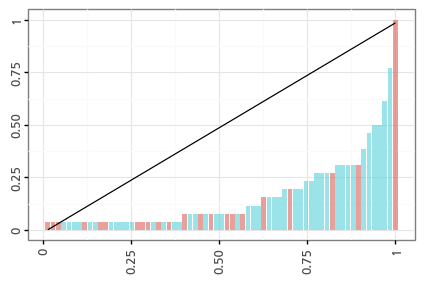


디지털 성범죄 강조 태그 후 분야 불평등도 = 0.7486505474921603






--------------------------------------------------
손해배상 분야
강조태그 전 상담 변호사수 : 96
강조태그 후 상담 변호사수 : 100
강조태그 전 상담 수 : 244
강조태그 후 상담 수 : 277

상담 변호사의 강조태그 여부
tags_exist
f    48
t    52
Name: lawyer_id, dtype: int64


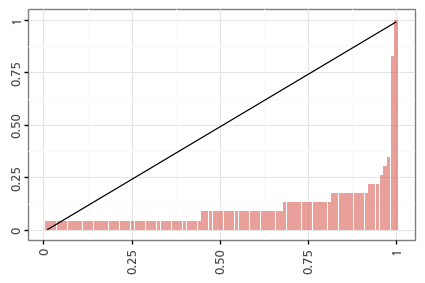


손해배상 강조 태그 전 분야 불평등도 = 0.8403854028664338


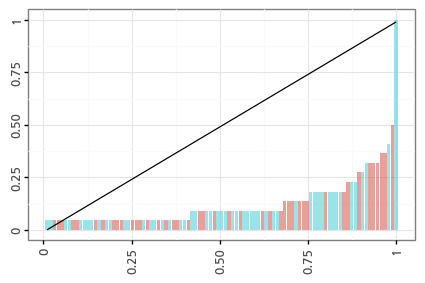


손해배상 강조 태그 후 분야 불평등도 = 0.8182624024175271






--------------------------------------------------
폭행/협박/상해 일반 분야
강조태그 전 상담 변호사수 : 80
강조태그 후 상담 변호사수 : 85
강조태그 전 상담 수 : 228
강조태그 후 상담 수 : 224

상담 변호사의 강조태그 여부
tags_exist
f    33
t    52
Name: lawyer_id, dtype: int64


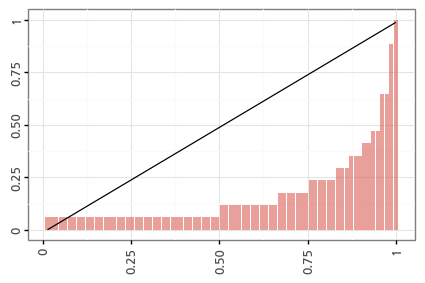


폭행/협박/상해 일반 강조 태그 전 분야 불평등도 = 0.7489090172200911


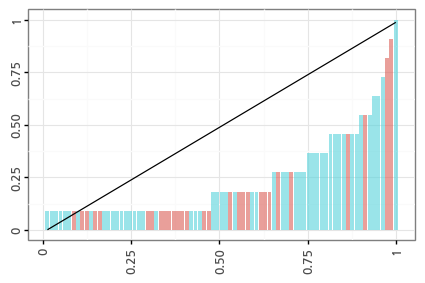


폭행/협박/상해 일반 강조 태그 후 분야 불평등도 = 0.6542932756924527






--------------------------------------------------
형사일반/기타범죄 분야
강조태그 전 상담 변호사수 : 100
강조태그 후 상담 변호사수 : 74
강조태그 전 상담 수 : 225
강조태그 후 상담 수 : 225

상담 변호사의 강조태그 여부
tags_exist
f    32
t    42
Name: lawyer_id, dtype: int64


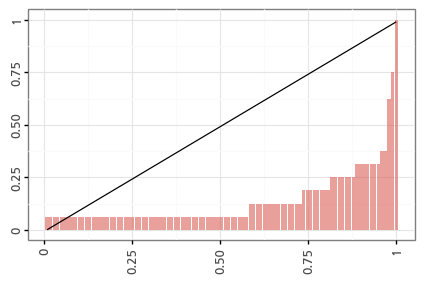


형사일반/기타범죄 강조 태그 전 분야 불평등도 = 0.7978267523722069


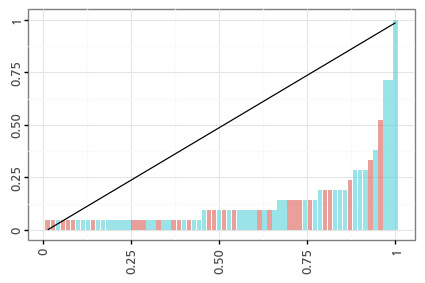


형사일반/기타범죄 강조 태그 후 분야 불평등도 = 0.7873275024295432






--------------------------------------------------
이혼 분야
강조태그 전 상담 변호사수 : 64
강조태그 후 상담 변호사수 : 59
강조태그 전 상담 수 : 228
강조태그 후 상담 수 : 215

상담 변호사의 강조태그 여부
tags_exist
f    26
t    33
Name: lawyer_id, dtype: int64


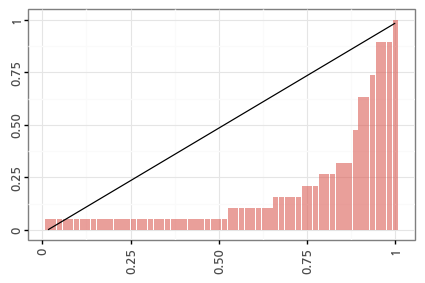


이혼 강조 태그 전 분야 불평등도 = 0.7008050824251054


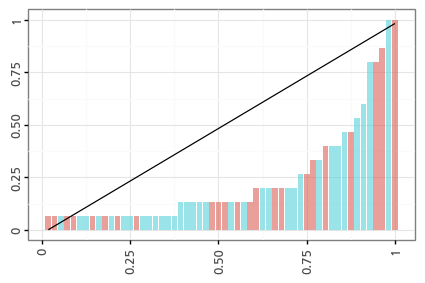


이혼 강조 태그 후 분야 불평등도 = 0.6416666666666667






--------------------------------------------------
사이버 명예훼손/모욕 분야
강조태그 전 상담 변호사수 : 49
강조태그 후 상담 변호사수 : 53
강조태그 전 상담 수 : 206
강조태그 후 상담 수 : 209

상담 변호사의 강조태그 여부
tags_exist
f    16
t    37
Name: lawyer_id, dtype: int64


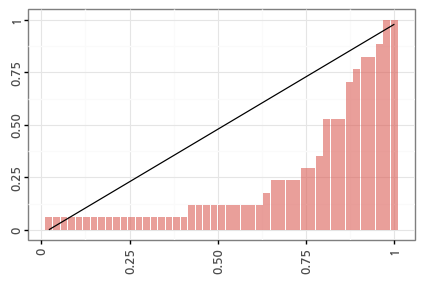


사이버 명예훼손/모욕 강조 태그 전 분야 불평등도 = 0.6041860836684153


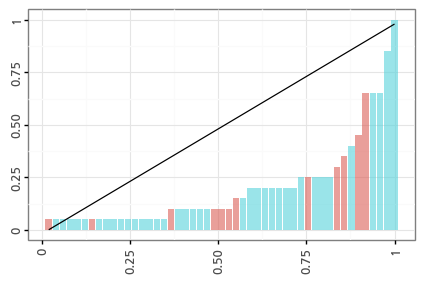


사이버 명예훼손/모욕 강조 태그 후 분야 불평등도 = 0.6905456059975009






--------------------------------------------------
성폭력/강제추행 등 분야
강조태그 전 상담 변호사수 : 79
강조태그 후 상담 변호사수 : 74
강조태그 전 상담 수 : 226
강조태그 후 상담 수 : 182

상담 변호사의 강조태그 여부
tags_exist
f    26
t    48
Name: lawyer_id, dtype: int64


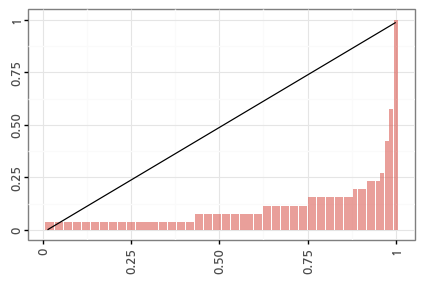


성폭력/강제추행 등 강조 태그 전 분야 불평등도 = 0.8376068376068375


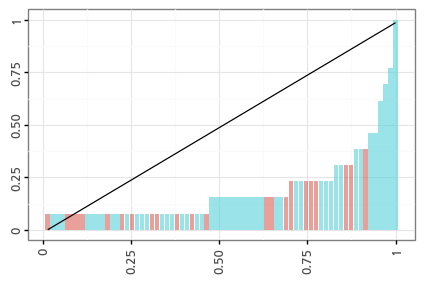


성폭력/강제추행 등 강조 태그 후 분야 불평등도 = 0.7295713609936979






--------------------------------------------------
계약일반/매매 분야
강조태그 전 상담 변호사수 : 71
강조태그 후 상담 변호사수 : 72
강조태그 전 상담 수 : 156
강조태그 후 상담 수 : 197

상담 변호사의 강조태그 여부
tags_exist
f    28
t    44
Name: lawyer_id, dtype: int64


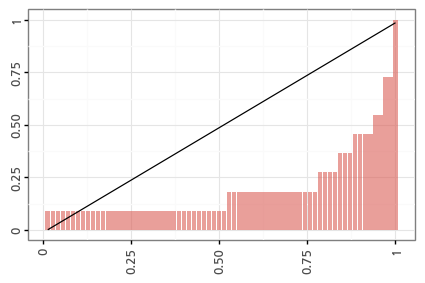


계약일반/매매 강조 태그 전 분야 불평등도 = 0.7166604823747681


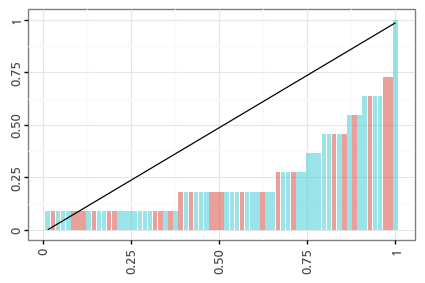


계약일반/매매 강조 태그 후 분야 불평등도 = 0.6411754597009797






--------------------------------------------------
사기/공갈 분야
강조태그 전 상담 변호사수 : 67
강조태그 후 상담 변호사수 : 72
강조태그 전 상담 수 : 175
강조태그 후 상담 수 : 172

상담 변호사의 강조태그 여부
tags_exist
f    28
t    44
Name: lawyer_id, dtype: int64


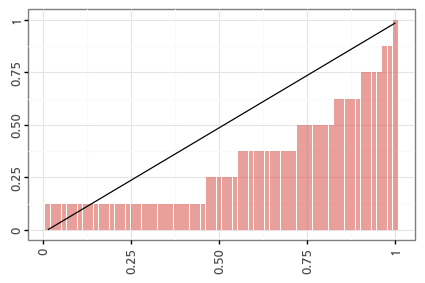


사기/공갈 강조 태그 전 분야 불평등도 = 0.5401170798898071


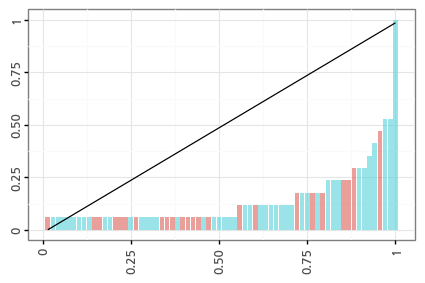


사기/공갈 강조 태그 후 분야 불평등도 = 0.7880622837370241






--------------------------------------------------


In [113]:
for idx, i in enumerate(extract_advice.groupby("adCategory_name")._id.count().sort_values(ascending = False).index[:10]) :
    
    print(f"{i} 분야")
    
    chk1 = extract_advice[extract_advice.adCategory_name == i]
    
    print("강조태그 전 상담 변호사수 : {}".format(chk1[chk1.tp == "b"].lawyer_id.nunique()))
    print("강조태그 후 상담 변호사수 : {}".format(chk1[chk1.tp == "a"].lawyer_id.nunique()))
    
    print("강조태그 전 상담 수 : {}".format(chk1[chk1.tp == "b"]._id.nunique()))
    print("강조태그 후 상담 수 : {}".format(chk1[chk1.tp == "a"]._id.nunique()))
    
    print("\n상담 변호사의 강조태그 여부")
    print(chk1[chk1.tp == "a"].groupby("tags_exist").lawyer_id.nunique())
    
    tmp1 = get_gini(chk1[chk1.tp == "b"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index(), "_id", group_key = "tags_exist", plot_tf = False)
    tmp2 = get_gini(chk1[chk1.tp == "a"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index(), "_id", group_key = "tags_exist", plot_tf = False)

    print("{} 강조 태그 전 분야 불평등도 = {}".format(i, get_gini(chk1[chk1.tp == "b"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index(), "_id", group_key = "tags_exist")))
    print("{} 강조 태그 후 분야 불평등도 = {}".format(i, get_gini(chk1[chk1.tp == "a"].groupby(["slug", "tags_exist"])._id.nunique().sort_values(ascending = False).reset_index(), "_id", group_key = "tags_exist")))
    print("\n"*2)
    # print("개선 전 지니계수 : {} \n개선 후 지니계수 : {}\n개선정도 : {}".format(tmp1, tmp2, tmp2 - tmp1))
    # print("개선정도 : {}".format(tmp1 - tmp2))
    
    print("\n"*2)
    print("-"*50) 